In [53]:
import cv2
import numpy as np
import open3d as o3d

In [54]:
# Load images
depth_img = cv2.imread("depth_map.jpg", cv2.IMREAD_UNCHANGED)
color_img = cv2.imread("your_image.png")
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

In [55]:
# Resize to match (if needed)
depth_img = cv2.resize(depth_img, (color_img.shape[1], color_img.shape[0]))

In [56]:
# Normalize depth to meters (or leave as-is for visualization)
depth = depth_img.astype(np.float32)
depth = cv2.normalize(depth, None, 0.1, 1.0, cv2.NORM_MINMAX)  # Fake scale

In [57]:
# Camera intrinsics (approximate for demo)
h, w = depth.shape
fx = fy = 500
cx, cy = w / 2, h / 2

In [58]:
# Create Open3D images
depth_o3d = o3d.geometry.Image(depth)
color_o3d = o3d.geometry.Image(color_img)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d, convert_rgb_to_intensity=False)

intrinsics = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)


In [59]:
# Create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

# Flip it for correct orientation
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

PointCloud with 466616 points.

In [60]:
# Visualize
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Wayland: The platform does not support setting the window position
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init
No plugins found, falling back on no decorations


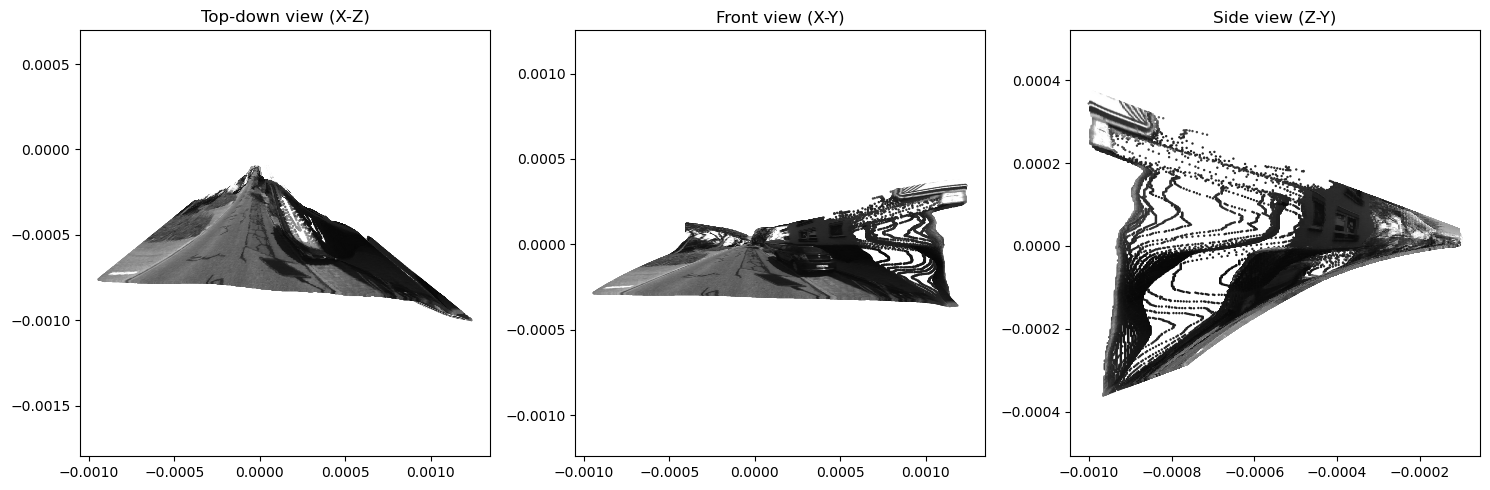

In [61]:
# Convert point cloud to numpy
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

# Plot 2D projections
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Top-down view (X, Z)
axs[0].scatter(points[:, 0], points[:, 2], c=colors, s=0.5)
axs[0].set_title("Top-down view (X-Z)")
axs[0].axis("equal")

# Front view (X, Y)
axs[1].scatter(points[:, 0], points[:, 1], c=colors, s=0.5)
axs[1].set_title("Front view (X-Y)")
axs[1].axis("equal")

# Side view (Z, Y)
axs[2].scatter(points[:, 2], points[:, 1], c=colors, s=0.5)
axs[2].set_title("Side view (Z-Y)")
axs[2].axis("equal")

plt.tight_layout()
plt.show()
